In [1]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import lightning as pl
import torchmetrics
import comet_ml
import os
from lightning.pytorch import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from comet_ml import Experiment

## CUDA SETUP

In [2]:
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.set_default_dtype(torch.float32)
    else:
        device = torch.device('cpu')
        torch.set_default_dtype(torch.float32)
    return device

device = setup_device()
print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Using cuda device


## DATASET

In [6]:
transform = transforms.Compose([
    # transforms.RandomRotation(10),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Values calculated from the ImageNet dataset
])

class Dataset(Dataset):
    def __init__(self, root_dir, dataset_type, transform=None):
        self.root_dir = root_dir
        self.dataset_type = dataset_type
        self.transform = transform
        self.classes_to_ignore = ["del", "nothing", "space"]

        self.classes = sorted([class_name for class_name in os.listdir(self.root_dir) if class_name not in self.classes_to_ignore])


        # self.classes if a dataset type is "test"
        if self.dataset_type == "test":
            test_classes = []
            for class_ in self.classes:
                if class_.endswith(".jpg"):
                    class_name = class_.replace("_test.jpg", "")
                elif class_.endswith(".png"):
                    class_name = class_.replace("_test.png", "")
                if class_name not in self.classes_to_ignore:
                    test_classes.append(class_name)
            self.classes = test_classes

        # Maping class names to numbers 
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes) if class_name not in self.classes_to_ignore}

    def __len__(self):
        if self.dataset_type == "train":
            dataset_len = sum([len(os.listdir(self.root_dir + class_)) for class_ in self.classes])
        elif self.dataset_type == "test":
            dataset_len = len(self.classes)
        return dataset_len
    
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("Index out of bounds")
        
        if self.dataset_type == "train":
            items_in_class = 3000 # Every class has 3000 items
            class_ = self.classes[index // items_in_class]
            image_path = os.path.join(self.root_dir, class_) + f"/{class_}{index % (items_in_class)+1}.jpg"
            # Applying label maping 
            label = self.class_to_idx[class_]
            
        elif self.dataset_type == "test":
            class_ = self.classes[index]
            image_path = os.path.join(self.root_dir, class_) + f"_test.jpg"
            # Applying label maping 
            label = self.class_to_idx[class_]

        # Loading image with cv2
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        # Converting to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # Transform
        if self.transform:
            image = self.transform(Image.fromarray(image))
        
        return image, label
        

In [7]:
# Train dataset and dataloader initialization
train_dataset = Dataset(root_dir="./dataset/asl_alphabet_train/", 
                        transform=transform,
                        dataset_type="train")

Dataset len:
78000

Dataset classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Random images from dataset:


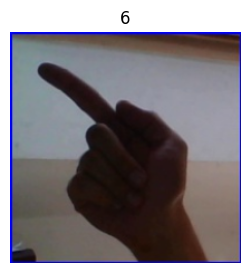

In [5]:
# Sanity check
print("Dataset len:")
print(len(train_dataset))

print("\nDataset classes:")
print(train_dataset.classes)

print("\nRandom images from dataset:")
img, label = train_dataset[random.randint(0, len(train_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()


In [6]:
# Train dataset and dataloader initialization
test_dataset = Dataset(root_dir="./dataset/asl_alphabet_test/", 
                        transform=transform,
                        dataset_type="test")

Dataset len:
26

Dataset classes:
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

Random image from dataset:


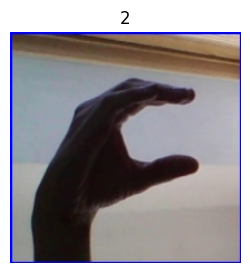

In [7]:
# Sanity check
print("Dataset len:")
print(len(test_dataset))

print("\nDataset classes:")
print(test_dataset.classes)

print("\nRandom image from dataset:")
img, label = test_dataset[random.randint(0, len(test_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()

## SPLITING DATA INTO TRAINING AND VALIDATION DATASETS

In [8]:
train_len = round(0.7 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_len, val_len, train_len + val_len == len(train_dataset)

(54600, 23400, True)

In [9]:
train_dataset_, val_dataset = random_split(train_dataset, [train_len, val_len])

In [10]:
# Sanity check once more

print(f"Number of training samples: {len(train_dataset_)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of train classes: {len(train_dataset_.dataset.classes)}")
print(f"Number of val classes: {len(val_dataset.dataset.classes)}")
print(f"Number of test samples: {len(test_dataset)}") 


Number of training samples: 54600
Number of validation samples: 23400
Number of train classes: 26
Number of val classes: 26
Number of test samples: 26


In [11]:
print(f"Train dataset classes: {train_dataset.classes}")
print(f"Validation dataset classes: {train_dataset.classes}")
print(f"Class-to-index mapping: {train_dataset.class_to_idx}")

Train dataset classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Validation dataset classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Class-to-index mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


## DATALOADERS

In [12]:
import os
num_workers = os.cpu_count()
print(f"Suggested num_workers: {num_workers}")

Suggested num_workers: 24


In [13]:
train_dataloader = DataLoader(train_dataset_, 
                              batch_size=32, 
                              shuffle=True, 
                              num_workers=0)

val_dataloader = DataLoader(val_dataset,
                            batch_size=32,
                            shuffle=False,
                            num_workers=0)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=32, 
                             shuffle=False, 
                             num_workers=0)


In [14]:
# Sanity check
def loader_sanity_check(loader):
    for batch_idx, (data, labels) in enumerate(loader):
        print(f"Batch nr: {batch_idx}")
        print(f"Batch size: {data.shape[0]}")
        print(f"Data shape: {data.shape}")
        print(f"Image shape: {data[0].shape}")
        print(f"Classes: {labels}")
        print(f"Num classes: {len(labels)}")
        break

In [15]:
loader_sanity_check(train_dataloader)

Batch nr: 0
Batch size: 32
Data shape: torch.Size([32, 3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Classes: tensor([13, 13, 12, 13, 23,  7, 24, 21,  3, 24,  6, 11, 14,  2,  6, 24, 10, 12,
        22, 16,  4,  0, 23, 20,  4, 11, 11,  5, 12, 21,  9, 14])
Num classes: 32


In [16]:
loader_sanity_check(val_dataloader)

Batch nr: 0
Batch size: 32
Data shape: torch.Size([32, 3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Classes: tensor([ 4, 11, 12,  6,  7, 17, 22, 20, 11,  1,  8, 21, 17, 19,  4,  0, 14, 13,
         7, 16,  0, 24, 19, 19, 14,  3, 19,  8, 25, 12,  5,  4])
Num classes: 32


In [17]:
loader_sanity_check(test_dataloader)

Batch nr: 0
Batch size: 26
Data shape: torch.Size([26, 3, 224, 224])
Image shape: torch.Size([3, 224, 224])
Classes: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25])
Num classes: 26


## PRETRAINED MODEL (MOBILE_NET)

In [18]:
# Using pretrained model (transfer learning)
weights = MobileNet_V2_Weights.DEFAULT
mobile_net_model = mobilenet_v2(weights=weights).to(device)

# Freeze the convolutional layers
for param in mobile_net_model.features.parameters():
    param.requires_grad = False

# Ensure classifier requires grad
for param in mobile_net_model.classifier.parameters():
    param.requires_grad = True

# Change classifier (fc) to satisfy aplication
num_classes = len(train_dataset.classes)
num_inputs = mobile_net_model.last_channel

mobile_net_model.fc = nn.Sequential(
    nn.Linear(num_inputs, 256),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(256, num_classes)).to(device)

In [19]:
print(mobile_net_model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [20]:
total_params = sum(p.numel() for p in mobile_net_model.parameters())
trainable_params = sum(p.numel() for p in mobile_net_model.parameters() if p.requires_grad)
frozen_params = sum(p.numel() for p in mobile_net_model.parameters() if not p.requires_grad)

print(f"All parameters: {total_params}")
print(f"Frozen parameters: {frozen_params}")
print(f"Trainable parameters: {trainable_params}")


All parameters: 3839490
Frozen parameters: 2223872
Trainable parameters: 1615618


## COMET_ML SETUP

In [21]:
from comet_ml import Experiment

# Initialize Comet.ml experiment
experiment = Experiment(
    api_key=os.getenv("COMET_API_KEY"),
    project_name="DLF-sign_letters_classification",
)

experiment.set_name("MobilNet - test")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/ziemmi13/dlf-sign-letters-classification/f3ebcf82c8c24edd9ed5361b44b48b06



## Define helper functions to logs gradients and weights

In [22]:
def to_numpy(x):
    return x.detach().numpy()


def update_gradient_map(model, gradmap):
    for name, layer in zip(model._modules, model.children()):
        if "activ" in name:
            continue

        if not hasattr(layer, "weight"):
            continue

        wname = "%s/%s.%s" % ("gradient", name, "weight")
        bname = "%s/%s.%s" % ("gradient", name, "bias")

        gradmap.setdefault(wname, 0)
        gradmap.setdefault(bname, 0)

        gradmap[wname] += layer.weight.grad
        gradmap[bname] += layer.bias.grad

    return gradmap


def log_gradients(gradmap, step):
    for k, v in gradmap.items():
        experiment.log_histogram_3d(to_numpy(v), name=k, step=step)


def log_weights(model, step):
    for name, layer in zip(model._modules, model.children()):
        if "activ" in name:
            continue

        if not hasattr(layer, "weight"):
            continue

        wname = "%s.%s" % (name, "weight")
        bname = "%s.%s" % (name, "bias")

        experiment.log_histogram_3d(to_numpy(layer.weight), name=wname, step=step)
        experiment.log_histogram_3d(to_numpy(layer.bias), name=bname, step=step)

## MODEL PARAMETERS

In [23]:
learning_rate = 0.0001
batch_size = 32
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobile_net_model.classifier.parameters(), lr=learning_rate, weight_decay=1e-4) # https://paperswithcode.com/method/weight-decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3) # https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
num_epochs = 5

hyper_params = {"batch_size": batch_size, "num_epochs": num_epochs, "learning_rate": learning_rate}
experiment.log_parameters(hyper_params)

In [24]:
def train_model(device, model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []

    model.to(device)

    print(f"Starting Training")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate batch loss (not divided by dataset size)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

           # Log every 50 batches
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
                experiment.log_metric("train_loss", loss.item(), step=batch_idx)

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)  # Average loss per batch
        train_accuracy = 100. * train_correct / train_total
        train_losses.append(epoch_loss)

        # Log epoch metrics
        experiment.log_metric("epoch_train_loss", epoch_loss, step=epoch)
        experiment.log_metric("epoch_train_accuracy", train_accuracy, step=epoch)

        val_losses = []
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(val_epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        print('-' * 60)

        # Log validation metrics
        experiment.log_metric("val_loss", val_epoch_loss, step=epoch)
        experiment.log_metric("val_accuracy", val_accuracy, step=epoch)

    return train_losses, val_losses

In [25]:
# Test loop
def test_model(device, model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Log test metrics
    experiment.log_metric("test_loss", test_loss)
    experiment.log_metric("test_accuracy", test_accuracy)

    return test_loss, test_accuracy

## TRAINING

In [26]:
train_losses, val_losses = train_model(device, mobile_net_model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

Starting Training
Epoch: 1, Batch: 0, Loss: 7.3055
Epoch: 1, Batch: 100, Loss: 5.0497
Epoch: 1, Batch: 200, Loss: 3.9403
Epoch: 1, Batch: 300, Loss: 3.4728
Epoch: 1, Batch: 400, Loss: 3.1722
Epoch: 1, Batch: 500, Loss: 3.1914
Epoch: 1, Batch: 600, Loss: 2.9709
Epoch: 1, Batch: 700, Loss: 3.0589
Epoch: 1, Batch: 800, Loss: 2.6695
Epoch: 1, Batch: 900, Loss: 2.6462
Epoch: 1, Batch: 1000, Loss: 2.5029
Epoch: 1, Batch: 1100, Loss: 2.3166
Epoch: 1, Batch: 1200, Loss: 2.5000
Epoch: 1, Batch: 1300, Loss: 2.0565
Epoch: 1, Batch: 1400, Loss: 2.1964
Epoch: 1, Batch: 1500, Loss: 2.0876
Epoch: 1, Batch: 1600, Loss: 1.9848
Epoch: 1, Batch: 1700, Loss: 2.0783
Epoch [1/5]
Training Loss: 2.9829, Training Accuracy: 25.63%
Validation Loss: 1.9756, Validation Accuracy: 59.07%
------------------------------------------------------------
Epoch: 2, Batch: 0, Loss: 2.1721
Epoch: 2, Batch: 100, Loss: 1.9738
Epoch: 2, Batch: 200, Loss: 1.9147
Epoch: 2, Batch: 300, Loss: 1.9290
Epoch: 2, Batch: 400, Loss: 1.857

In [27]:
# Saving model and weights
torch.save(mobile_net_model, "./models/MobileNet_test1_model")
torch.save(mobile_net_model.state_dict(), "./models/MobileNet_test1_weights")

## Log the Model to Comet

In [28]:
from comet_ml.integration.pytorch import log_model

log_model(experiment, mobile_net_model, "MobileNet model - sign letters classification")

## End Experiment

In [29]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : MobilNet - test
COMET INFO:     url                   : https://www.comet.com/ziemmi13/dlf-sign-letters-classification/f3ebcf82c8c24edd9ed5361b44b48b06
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch_train_accuracy [5] : (25.63003663003663, 84.0952380952381)
COMET INFO:     epoch_train_loss [5]     : (0.8005458297405456, 2.9829467553176165)
COMET INFO:     train_loss [90]          : (0.6496592164039612, 7.305474281311035)
COMET INFO:     val_accuracy [5]         : (59.072649572649574, 88.6923076923077)
COMET INFO:     val_loss [5]             : (0.656095441899013, 1.9755793529781487)
COMET INFO:   Others:
COMET INFO:     Name : MobilN

## TESTING

In [30]:
test_loss, test_accuracy = test_model(device, mobile_net_model, test_dataloader, criterion)

Test Loss: 0.0102, Test Accuracy: 100.00%


In [31]:
loaded_model = torch.load(f="./models/MobileNet_test1_model", weights_only=False)
loaded_model.to(device)
print(loaded_model)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [38]:
from PIL import Image
from torchvision import transforms

# Funkcja do przewidywania klasy pojedynczego obrazu
def predict_image(image_path, model, device, class_names):
    # Wczytanie i przetworzenie obrazu
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Rozmiar wejścia dla ResNet50
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizacja ImageNet
    ])

    image = Image.open(image_path).convert('RGB')  # Konwersja na RGB
    image_tensor = transform(image).unsqueeze(0).to(device)  # Dodanie wymiaru wsadowego

    model.to(device)
    # Przewidywanie
    model.eval()
    with torch.inference_mode():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)

    # Zwracanie nazwy klasy
    predicted_class = class_names[predicted.item()]
    return predicted_class

# Przykład użycia
image_path = "./dataset/test_images/i.png"
class_names = train_dataset.classes  # Zakładając, że masz listę klas
predicted_class = predict_image(image_path, loaded_model, device, class_names)

print(f"Predicted class: {predicted_class}")


Predicted class: G
